<a href="https://colab.research.google.com/github/Sanjayvaradha/Computer-Vision/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  !pip install tensorflow==2.4.1 opencv-python matplotlib

     |████████████████▉               | 207.0 MB 1.5 MB/s eta 0:02:06
ERROR: Operation cancelled by user


In [ ]:
import os
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, Input,Layer
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# pos = os.path.join('data','pos')
# neg = os.path.join('data','neg')
# anch = os.path.join('data','anch')

In [ ]:
#os.makedirs(pos)
#os.makedirs(neg)
#os.makedirs(anch)


In [ ]:
anch='/content/drive/MyDrive/data/anc'
pos='/content/drive/MyDrive/data/pos'
neg= '/content/drive/MyDrive/data/neg'

In [ ]:
#neg='/content/sample_data/neg'

In [ ]:
#!tar -xf lfw.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
# for directory in os.listdir('lfw'):
#   for files in os.listdir(os.path.join('lfw',directory)):
#     exsiting = os.path.join('lfw',directory,files)
#     new = os.path.join(neg,files)
#     os.replace(exsiting,new)

In [ ]:
anc = tf.data.Dataset.list_files(anch+'/*.jpg').take(300)
pos = tf.data.Dataset.list_files(pos+'/*.jpg').take(300)
neg = tf.data.Dataset.list_files(neg+'/*.jpg').take(300)

In [ ]:
test=anc.as_numpy_iterator()

In [ ]:
test.next()

b'/content/drive/MyDrive/data/anc/1c1491aa-4261-11ec-bc1e-acd1b8d9acb4.jpg'

In [ ]:
def preprocess(filepath):
  byte_img = tf.io.read_file(filepath)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img,(105,105))
  img = img/255.0
  return img

In [ ]:
pos_anch = tf.data.Dataset.zip((anc,pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(anc)))))
neg_anch = tf.data.Dataset.zip((anc,neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anc)))))
data = pos_anch.concatenate(neg_anch)


In [ ]:
example=pos_anch.as_numpy_iterator()
example.next()

(b'/content/drive/MyDrive/data/anc/1920d742-4261-11ec-9012-acd1b8d9acb4.jpg',
 b'/content/drive/MyDrive/data/pos/582b5ce0-4261-11ec-8d73-acd1b8d9acb4.jpg',
 1.0)

In [ ]:
def preprocessor_twin(anchor,verification,label):
  return(preprocess(anchor),preprocess(verification),label)

In [ ]:
data = data.map(preprocessor_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [ ]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def embedding_model():
  inp = Input(shape=(105,105,3),name='embedding')
  c1 = Conv2D(64,(10,10),activation='relu')(inp)
  m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

  c2 = Conv2D(128,(7,7),activation='relu')(m1)
  m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

  c3 = Conv2D(128,(4,4),activation='relu')(m2)
  m3 = MaxPooling2D(64,(2,2),padding='same')(c3)

  c4 = Conv2D(256,(4,4),activation='relu')(m3)

  f1 = Flatten()(c4)
  d1 = Dense(4096,activation='sigmoid')(f1)

  return Model(inputs=[inp],outputs=[d1],name='embedding')

  

In [ ]:
embedding = embedding_model()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [ ]:
class L1Dist(Layer):
  
  def __init__(self,**kwargs):
    super().__init__()

  def call(self,anchor_img,validation_img):
    return tf.math.abs(anchor_img-validation_img) 

In [ ]:
def siamese_model():
  anchor_img= Input(shape=(105,105,3),name='anchor_img')
  validation_img=Input(shape=(105,105,3),name='validation_img')
  L1 = L1Dist()
  distance=L1(embedding(anchor_img),embedding(validation_img))
  classifiers = Dense(1,activation='sigmoid')(distance)


  return Model(inputs=[anchor_img,validation_img],outputs=classifiers,name='siamese_network')

In [ ]:
siamese_network=siamese_model()

In [ ]:
siamese_network.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['anchor_img[0][0]',             
                                                                  'validation_img[0]

In [ ]:
losses = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_network=siamese_network)

In [ ]:
@tf.function
def training_step(data):

  with tf.GradientTape() as tape:

    X = data[0:2]
    y = data[-1]

    yhat = siamese_network(X, training = True)
    loss = losses(y,yhat)
  
  grad = tape.gradient(loss,siamese_network.trainable_variables)

  optimizer.apply_gradients(zip(grad, siamese_network.trainable_variables))

    

  return loss 


In [ ]:
def train_loop(train,Epochs):

  for epochs in range(1,Epochs+1):
    print(f'\n Epochs-->{epochs}/{Epochs}')
    progbar = tf.keras.utils.Progbar(len(train))


    for idx, data in enumerate(train):
      training_step(data)
      progbar.update(idx+1)
    

    if epochs % 10 == 0:

      checkpoint.save(file_prefix=checkpoint_prefix)




In [ ]:
train_loop(train_data,50)


 Epochs-->1/50
27/27 [==============================] - 171s 753ms/step

 Epochs-->2/50
27/27 [==============================] - 20s 756ms/step

 Epochs-->3/50
27/27 [==============================] - 20s 758ms/step

 Epochs-->4/50
27/27 [==============================] - 20s 762ms/step

 Epochs-->5/50
27/27 [==============================] - 20s 766ms/step

 Epochs-->6/50
27/27 [==============================] - 20s 754ms/step

 Epochs-->7/50
27/27 [==============================] - 20s 746ms/step

 Epochs-->8/50
27/27 [==============================] - 20s 744ms/step

 Epochs-->9/50
27/27 [==============================] - 20s 743ms/step

 Epochs-->10/50
27/27 [==============================] - 20s 744ms/step

 Epochs-->11/50
27/27 [==============================] - 19s 747ms/step

 Epochs-->12/50
27/27 [==============================] - 19s 738ms/step

 Epochs-->13/50
27/27 [==============================] - 20s 742ms/step

 Epochs-->14/50
27/27 [==============================] - 1

In [ ]:

from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = model.predict([test_input, test_val])
y_hat

array([[9.9981362e-01],
       [1.0000000e+00],
       [4.2037036e-06],
       [2.0568709e-04],
       [9.9980980e-01],
       [9.9951148e-01],
       [1.0000000e+00],
       [1.4938646e-09],
       [9.9999988e-01],
       [9.9999857e-01],
       [1.0000000e+00],
       [3.0827675e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9975926e-01],
       [1.0000000e+00]], dtype=float32)

In [ ]:
prediction=[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
prediction

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]

In [ ]:
y_true

array([1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

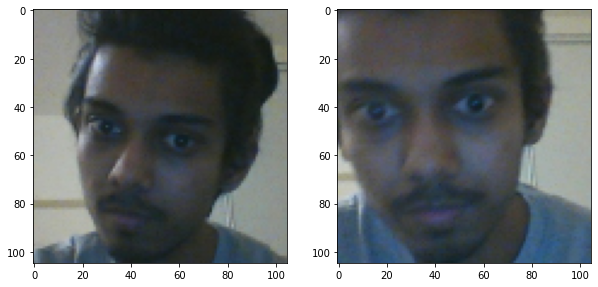

In [ ]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [ ]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
siamese_network.save('siamesenetwork_final.h5')

In [ ]:
siamese_network='/content/drive/MyDrive/data/siamese_model.h5'

In [ ]:

model = tf.keras.models.load_model(siamese_network, 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_img (InputLayer)        [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['anchor_img[0][0]',             
                                                                  'validation_img[0]

In [ ]:
verify_img='/content/sample_data/verification_image'

In [ ]:
verify_img

'/content/sample_data/verification_image'

In [ ]:
for image in os.listdir(os.path.join('sample_data', 'verification_image')):
    validation_img = os.path.join('sample_data', 'verification_image', image)
    print(validation_img)

sample_data/verification_image/4d726bd8-4261-11ec-9ac8-acd1b8d9acb4.jpg
sample_data/verification_image/1eb8a65c-4261-11ec-8dbe-acd1b8d9acb4.jpg
sample_data/verification_image/525e52b3-4261-11ec-89f0-acd1b8d9acb4.jpg
sample_data/verification_image/531c86bb-4261-11ec-b0cf-acd1b8d9acb4.jpg
sample_data/verification_image/524f1225-4261-11ec-90e7-acd1b8d9acb4.jpg
sample_data/verification_image/1e0922b7-4261-11ec-affb-acd1b8d9acb4.jpg
sample_data/verification_image/1eabfc77-4261-11ec-9e2a-acd1b8d9acb4.jpg
sample_data/verification_image/504a949a-4261-11ec-aa36-acd1b8d9acb4.jpg
sample_data/verification_image/532bb6bf-4261-11ec-acf4-acd1b8d9acb4.jpg
sample_data/verification_image/59e517ed-4261-11ec-adde-acd1b8d9acb4.jpg
sample_data/verification_image/513a3cd5-4261-11ec-bfb5-acd1b8d9acb4.jpg
sample_data/verification_image/52c9d17e-4261-11ec-86eb-acd1b8d9acb4.jpg
sample_data/verification_image/522efe54-4261-11ec-877f-acd1b8d9acb4.jpg
sample_data/verification_image/4de27850-4261-11ec-a4c6-acd1b8d9a

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('sample_data', 'verification_image')):
      validation_img = os.path.join('sample_data', 'verification_image', image)
      input_img = preprocess(os.path.join('sample_data', 'input_image', 'input_image.jpg'))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified